# Chapter 3: Classification

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X.shape, y.shape)

(70000, 784) (70000,)


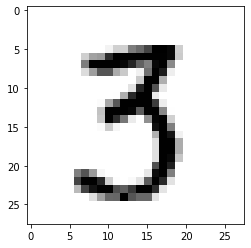

In [5]:
plt.imshow(X[np.random.randint(0, 70000)].reshape(28, 28), cmap='binary')

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    precision_recall_curve,
    roc_curve
)

This step below is kind of interesting. We're using cross validation on training set to get untainted predictions since `cross_val_predict` is splitting into test/train sets on CV folds. 

In [8]:
clf = SGDClassifier(random_state=42)

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=3)

### Precision/Recall Trade-Off

In [9]:
print(confusion_matrix(y_train_5, y_train_pred))
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1:", f1_score(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]
Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1: 0.7325171197343846


In [10]:
y_scores = cross_val_predict(clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [11]:
prec, rec, thresh = precision_recall_curve(y_train_5, y_scores)

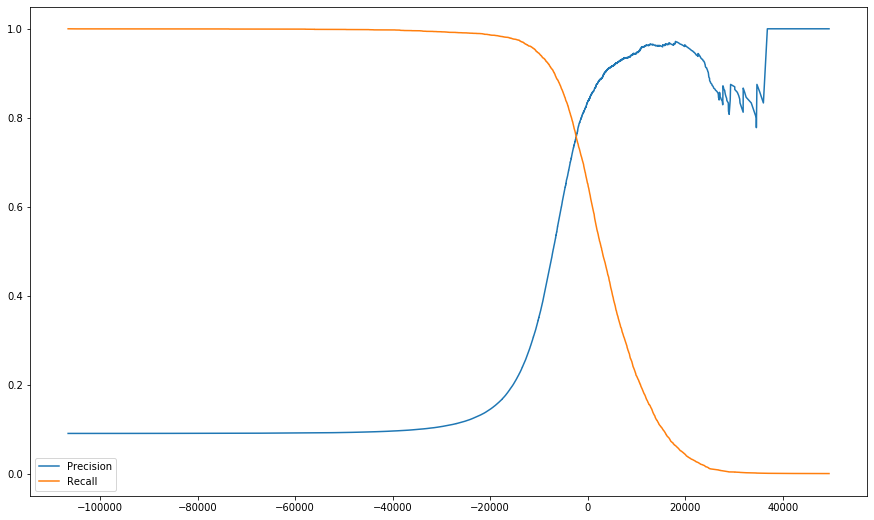

In [13]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(thresh, prec[:-1], label="Precision", ax=ax)
sns.lineplot(thresh, rec[:-1], label="Recall", ax=ax)

In [14]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

### The ROC Curve
Receiver operating characteristic. Plots true positive rate against false positive rate.

In [15]:
from sklearn.metrics import roc_auc_score

In [20]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    sns.lineplot(fpr, tpr, label=label)
    sns.lineplot([0, 1], [0, 1])

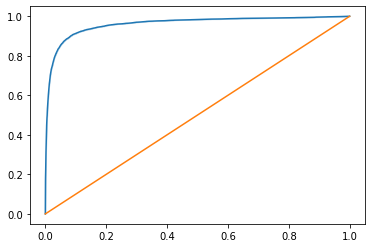

In [21]:
plot_roc_curve(fpr, tpr)

In [16]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
sns.plot(fpr, tpr, )